# KPI demo

This notebook demonstrates how to compute KPIs with [xlte](https://lab.nexedi.com/kirr/xlte).
It is based on [_kpidemo_](https://lab.nexedi.com/kirr/xlte/blob/master/demo/kpidemo.py)
program from that repository.

--------

As outlined in [xlte/kpi.py](https://lab.nexedi.com/kirr/xlte/blob/master/kpi.py)
module documentation the pipeline to compute a KPI is as follows:

```
    ─────────────
   │ Measurement │  Measurements   ────────────────       ──────
   │             │ ─────────────→ │ MeasurementLog │ ──→ │ Calc │ ──→  KPI
   │   driver    │                 ────────────────       ──────
    ─────────────
```

Below we will organize this pipeline and execute it step by step.

**Step 1**.
Setup driver to provide measurements data.<br>
Such a driver is specific to eNB implementation. Below we use [amari.kpi.LogMeasure](https://lab.nexedi.com/kirr/xlte/blob/master/amari/kpi.py) that is
specific to Amarisoft and retrieves measurements data from _enb.xlog_ . The _enb.xlog_ itself was produced by [amari.xlog](https://lab.nexedi.com/kirr/xlte/blob/master/amari/xlog.py) module via running `xamari xlog ws://localhost:9001 stats/15s` command on the eNodeB.

In [1]:
from xlte.amari import kpi as akpi
from urllib.request import urlopen

xlog_uri = "https://lab.nexedi.com/kirr/misc/raw/162307b9/lte/20221211-overload.xlog"
fxlog = urlopen(xlog_uri)
alogm = akpi.LogMeasure(fxlog,  # amari.kpi.LogMeasure converts enb.xlog into kpi.Measurements
                        open('/dev/null', 'r'))

**Step 2**. Setup [kpi.MeasurementLog](https://lab.nexedi.com/kirr/xlte/blob/master/kpi.py) and load measurements data into it.<br>
The data, as contained in the measurement log, is kept there in the form
of [kpi.Measurement](https://lab.nexedi.com/kirr/xlte/blob/master/kpi.py), which is driver-independent representation for
KPI-related measurement data.

In [2]:
from xlte import kpi

def load_measurements(alogm: akpi.LogMeasure) -> kpi.MeasurementLog:
    mlog = kpi.MeasurementLog()
    try:
        while 1:
            m = alogm.read()
            if m is None:
                break
            mlog.append(m)
    finally:
        alogm.close()
    return mlog

mlog = load_measurements(alogm)

**Step 3**. Compute <u>E-RAB Accessibility</u> KPI over _MeasurementLog_ with specified granularity period.<br>
We partition entries in the measurement log by specified time period and further use [kpi.Calc](https://lab.nexedi.com/kirr/xlte/blob/master/kpi.py) to compute the KPI over each period.

In [3]:
import numpy as np
from datetime import datetime

# calc_each_period partitions mlog data into periods and yields kpi.Calc for each period.
def calc_each_period(mlog: kpi.MeasurementLog, tperiod: float): # -> yield kpi.Calc
    τ = mlog.data()[0]['X.Tstart']
    for m in mlog.data()[1:]:
        τ_ = m['X.Tstart']
        if (τ_ - τ) >= tperiod:
            calc = kpi.Calc(mlog, τ, τ+tperiod)
            τ = calc.τ_hi
            yield calc

tperiod = 1*60  # 1 minute
vτ = []
vInititialEPSBEstabSR = []
vAddedEPSBEstabSR     = []

for calc in calc_each_period(mlog, tperiod):
    vτ.append(calc.τ_lo)
    _ = calc.erab_accessibility()        # E-RAB Accessibility
    vInititialEPSBEstabSR.append(_[0])
    vAddedEPSBEstabSR    .append(_[1])

vτ                      = np.asarray([datetime.fromtimestamp(_) for _ in vτ])
vInititialEPSBEstabSR   = np.asarray(vInititialEPSBEstabSR)
vAddedEPSBEstabSR       = np.asarray(vAddedEPSBEstabSR)

**Step 4**. Plot computed KPI.<br>
The E-RAB Accessibility KPI has two parts: _initial E-RAB establishment
success rate_, and _additional E-RAB establishment success rate_. [kpi.Calc](https://lab.nexedi.com/kirr/xlte/blob/master/kpi.py)
provides both of them in the form of their confidence intervals. The
lower margin of the confidence interval coincides with 3GPP definition of
the KPI. The upper margin, however, provides information of how
confident, or how unsure we are about described value. For example if
there is enough data to compute the KPI precisely during particular
period, the low and high margins of the confidence interval will be the
same. However if, during a period, there is no measurements data at all,
the confidence interval will be \[0,100\] meaning full uncertainty - because
there is no measurements data we don't know how accessible eNB was during
that period of time. The width of a confidence interval is not
necessarily 100. For example if during a period, there is no measurement
data only for part of that period, the KPI value is computed from the
other times in the period when there is data, and the confidence interval
will be thinner.

For each of the parts we plot both its lower margin and the whole
confidence interval area.

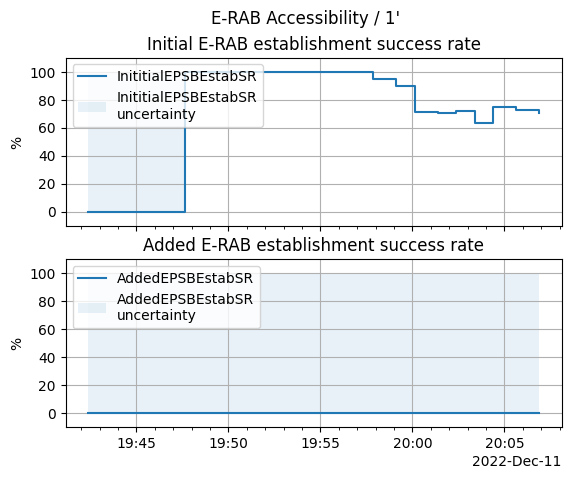

In [4]:
from xlte.demo import kpidemo
import matplotlib.pyplot as plt

kpidemo.figplot_erab_accessibility(plt.gcf(), vτ, vInititialEPSBEstabSR, vAddedEPSBEstabSR, tperiod)

The plot corresponds to scenario with 3 parts:

1. the first part is "silence" - when there is no mobiles around and so the base station is not being used by UEs at all. As the base station is not being used we don't know the probablity of successfully establishing an E-RAB. This is reflected by [0,100] confidence interval that means "full uncertainty".

2. the second period is when 5 UE start to attach and detach to eNB constantly. Each mobile attaches for 20 seconds and does a ping test, then goes to power_off for 5 seconds. The base station can handle that just ok with all E-RAB establishment requests succeeding. This is reflected by *InititialEPSBEstabSR*=100%.

3. The third period is when 100 UE are around the base station. They all try to do the same power_on+ping+power_off test from "2", but since the number of UE is high, the base station gets overloaded and cannot attach them all. This is reflected by decreased *InititialEPSBEstabSR*.

In this test there was no additional E-RAB established, so *AddedEPSBEstabSR* is full uncertainty all the time.

This completes the overview of KPI computation pipeline.

----

Let's now look at <u>E-UTRAN IP Throughput</u> KPI.

To showcase this KPI we use the same computation pipeline as explained above and _enb.xlog_ from another test. This _enb.xlog_ was produces by running `xamari xlog ws://localhost:9001 stats/3s x.drb_stats/3s` and includes information about flows of data on radio bearers.

We load the data as explained above in steps 1 and 2,

In [5]:
xlog_uri = "https://lab.nexedi.com/kirr/misc/raw/1a88e053/lte/20230307-thpdemo.xlog"
fxlog = urlopen(xlog_uri)
alogm = akpi.LogMeasure(fxlog, open('/dev/null', 'r'))
mlog  = load_measurements(alogm)

compute the KPI similarly to how it was explained above in step 3,

In [6]:
tperiod = 3  # 3 seconds
vτ = []
vIPThp_qci = []

for calc in calc_each_period(mlog, tperiod):
    vτ.append(calc.τ_lo)
    _ = calc.eutran_ip_throughput()     # E-UTRAN IP Throughput
    vIPThp_qci.append(_)

vτ          = np.asarray([datetime.fromtimestamp(_) for _ in vτ])
vIPThp_qci  = np.asarray(vIPThp_qci)

and plot the result similarly to step 4.

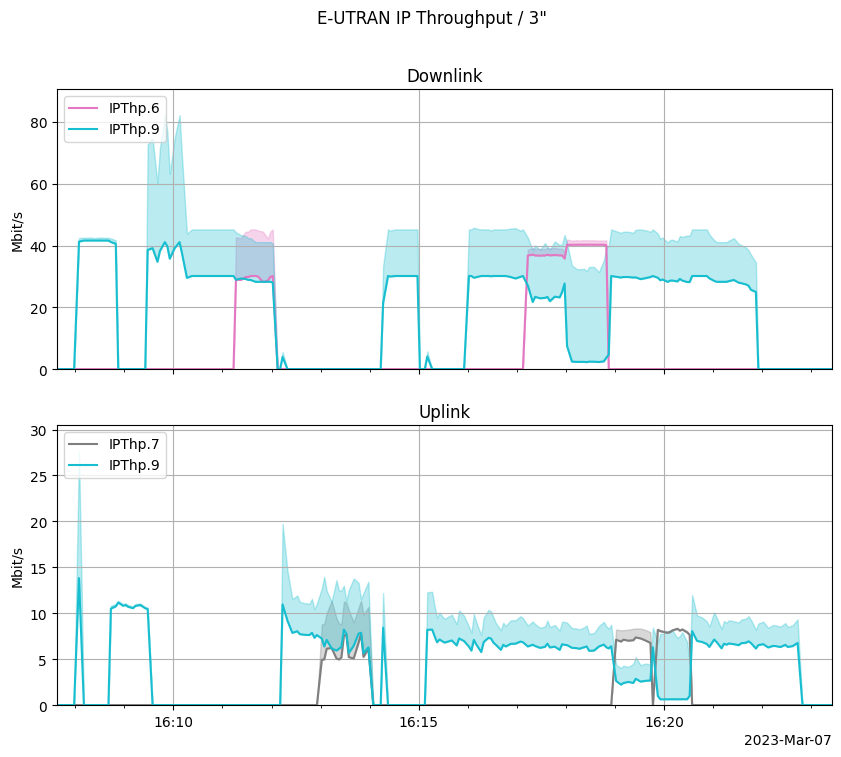

In [7]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
kpidemo.figplot_eutran_ip_throughput(fig, vτ, vIPThp_qci, tperiod)

The plot corresponds to throughput test experiment.

Here it is 5MHz FDD cell with 2x2 MIMO. Ideal downlink throughput is around 48 Mbit/s and ideal uplink throughput is around 18 MBit/s. In the test DL MCS was around 26 - this results in DL radio throughput around 41 Mbit/s (256QAM). In the test UL MCS was around 23-25 - this results in UL radio throughput around 10.5 Mbit/s (64QAM).

The test consists of the following parts:

1. 8'00" - 8'50" : DL: one UE is flooded with 1K UDP packets.
2. 8'40" - 9'30" : UL: one UE floods 1K UDP packets.
3. 9'30" - 10'20" : DL: one UE is sent 10K UDP bursts with 100ms pauses in between bursts.
4. 10'20" - 11'10" : DL: one UE is sent 11K UDP burst with 100ms pauses.
5. 11'10" - 12'10" : DL: additionally the same UE is simultaneously sent 11K UDP burst with 100ms pauses over QCI 6.
6. 12'10" - 12'50" : UL: one UE sends 3K UDP bursts with 100ms pauses.
7. 12'50" - 14'10" : UL: additionally the same UE simultaneously sends 3K UDP burts with 100ms pauses over QCI 7.
8. 14'10" - 15'00" : DL: 10 UEs are simultaneously sent 11K UDP bursts with 500ms pauses on every burst stream. Transmission to different UEs are likely separated in time.
9. 15'10" - 15'50" : UL: 10 UEs simultaneously send 3K UDP bursts with 500ms pauses on every burst stream. Transmissions from different UEs are likely separated in time.
10. 15'50" - 17'10" : DL + UL: 10 UEs are simultaneously being sent UDP bursts and send UDP bursts themselves as described in parts 8 and 9.
11. 17'10" - 18'00" : DL + UL: in addition to part 10 downlink overload is simulated by one UE being sent 20K UDP bursts with small 10ms pauses in between those bursts on QCI 6.
12. 18'00" - 18'50" : DL + UL: downlink overload becomes more severe - now it is 40K UDP bursts with even smaller 5ms pauses.
13. 18'50" - 19'40" : DL + UL: downlink overload is gone - now uplink overload is simulated by one UE additionally sending 5K UDP bursts every 10ms on QCI 7.
14. 19'40" - 20'30" : DL + UL: uplink overload becomese more sever - now it is 10K UDP bursts with even smaller 5ms pauses.
15. 20'30" - 21'50" : DL + UL: uplink overload is gone - now everything is running the same way as described in part 10.
16. 21'50" - 22'40" : UL: downlink activity is stopped
17. 22'40" - 23'30" : ø: uplink activity is also stopped

The graphs display uncertainty window for measured downlink and uplink throughput on non-silent QCIs.
The uncertainties are relateively big due to the way how throughput is currently measured with heuristics and estimates in [xlte/amari/drb.py](https://lab.nexedi.com/kirr/xlte/blob/master/amari/drb.py) .

END